In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# ============================================================
# 설정값
# ============================================================
# 손상 파라미터 설정
CORRUPTION_RATIO = 0.5  # 데이터의 50%를 손상시킴
LOSS_RATIO = 0.2  # 각 대화의 20%를 소실시킴

# 모델 하이퍼파라미터
MAX_WORDS = 10000
MAX_LEN = 100
EMBEDDING_DIM = 128
LSTM_UNITS = 64
EPOCHS = 5
BATCH_SIZE = 32

print("=" * 60)
print("LSTM 기반 STT 손상 데이터 평가 시스템")
print("=" * 60)


LSTM 기반 STT 손상 데이터 평가 시스템


In [3]:
# ============================================================
# 1. 데이터 로드 및 전처리
# ============================================================
print("\n[1단계] 데이터 로드 중...")

# 파일 업로드
from google.colab import files
print("\n학습 데이터 파일들을 업로드해주세요:")
print("- normal_gemini.csv")
print("- normal_gpt.csv")
print("- open_source_combined.csv")
print("- specific_gemini.csv")
print("- specific_gpt.csv")

uploaded = files.upload()

# 데이터 로드
df_normal_gemini = pd.read_csv('normal_gemini.csv')
df_normal_gpt = pd.read_csv('normal_gpt.csv')
df_opensource = pd.read_csv('open_source_combined.csv')
df_specific_gemini = pd.read_csv('specific_gemini.csv')
df_specific_gpt = pd.read_csv('specific_gpt.csv')

# 결측치 제거
df_normal_gemini = df_normal_gemini.dropna(subset=['dialogue', 'label'])
df_normal_gpt = df_normal_gpt.dropna(subset=['dialogue', 'label'])
df_opensource = df_opensource.dropna(subset=['dialogue', 'label'])
df_specific_gemini = df_specific_gemini.dropna(subset=['dialogue', 'label'])
df_specific_gpt = df_specific_gpt.dropna(subset=['dialogue', 'label'])

print(f"✓ normal_gemini: {len(df_normal_gemini)} samples")
print(f"✓ normal_gpt: {len(df_normal_gpt)} samples")
print(f"✓ open_source_combined: {len(df_opensource)} samples")
print(f"✓ specific_gemini: {len(df_specific_gemini)} samples")
print(f"✓ specific_gpt: {len(df_specific_gpt)} samples")

# 데이터 통합 및 가중치 부여
# opensource : gemini(normal+specific) : gpt(normal+specific) = 1.3 : 1.3 : 0.6
df_gemini = pd.concat([df_normal_gemini, df_specific_gemini], ignore_index=True)
df_gpt = pd.concat([df_normal_gpt, df_specific_gpt], ignore_index=True)

# 각 데이터셋에 소스 태그 추가
df_opensource['source'] = 'opensource'
df_gemini['source'] = 'gemini'
df_gpt['source'] = 'gpt'

# 전체 학습 데이터 통합
train_data = pd.concat([df_opensource, df_gemini, df_gpt], ignore_index=True)

print(f"\n총 학습 데이터: {len(train_data)} samples")
print(f"  - opensource: {len(df_opensource)}")
print(f"  - gemini: {len(df_gemini)}")
print(f"  - gpt: {len(df_gpt)}")



[1단계] 데이터 로드 중...

학습 데이터 파일들을 업로드해주세요:
- normal_gemini.csv
- normal_gpt.csv
- open_source_combined.csv
- specific_gemini.csv
- specific_gpt.csv


Saving normal_gemini.csv to normal_gemini.csv
Saving normal_gpt.csv to normal_gpt.csv
Saving open_source_combined.csv to open_source_combined.csv
Saving specific_gemini.csv to specific_gemini.csv
Saving specific_gpt.csv to specific_gpt.csv
✓ normal_gemini: 1615 samples
✓ normal_gpt: 1598 samples
✓ open_source_combined: 4978 samples
✓ specific_gemini: 1615 samples
✓ specific_gpt: 1497 samples

총 학습 데이터: 11303 samples
  - opensource: 4978
  - gemini: 3230
  - gpt: 3095


In [4]:
# ============================================================
# 2. 평가 데이터 로드
# ============================================================
print("\n평가 데이터 파일을 업로드해주세요:")
print("- specific_stt_errors_full.csv")

uploaded_eval = files.upload()

df_eval = pd.read_csv('specific_stt_errors_full.csv')
df_eval = df_eval.dropna(subset=['original', 'converted', 'original_label'])

print(f"\n평가 데이터 로드 완료: {len(df_eval)} samples")


평가 데이터 파일을 업로드해주세요:
- specific_stt_errors_full.csv


Saving specific_stt_errors_full.csv to specific_stt_errors_full.csv

평가 데이터 로드 완료: 1536 samples


In [5]:
# ============================================================
# 3. 세 가지 평가 데이터셋 생성
# ============================================================
print("\n[2단계] 평가 데이터셋 생성 중...")

# 데이터셋 1: 원본 데이터
eval_original = df_eval[['original', 'original_label']].copy()
eval_original.columns = ['dialogue', 'label']

# 데이터셋 2: STT 손상 데이터
eval_stt_corrupted = df_eval[['converted', 'original_label']].copy()
eval_stt_corrupted.columns = ['dialogue', 'label']

# 데이터셋 3: 추가 손상 데이터 (일부 대화 소실)
def corrupt_dialogue(text, loss_ratio=0.2):
    """대화의 일부를 랜덤으로 소실시키는 함수"""
    if pd.isna(text) or text == '':
        return text

    words = text.split()
    if len(words) <= 1:
        return text

    num_words_to_remove = max(1, int(len(words) * loss_ratio))
    indices_to_remove = random.sample(range(len(words)), num_words_to_remove)

    corrupted_words = [word for i, word in enumerate(words) if i not in indices_to_remove]
    return ' '.join(corrupted_words)

eval_additional_corrupted = eval_stt_corrupted.copy()

# 전체 데이터의 CORRUPTION_RATIO만큼 추가 손상
num_to_corrupt = int(len(eval_additional_corrupted) * CORRUPTION_RATIO)
indices_to_corrupt = random.sample(range(len(eval_additional_corrupted)), num_to_corrupt)

print(f"\n추가 손상 적용:")
print(f"  - 전체 데이터: {len(eval_additional_corrupted)} samples")
print(f"  - 손상될 데이터: {num_to_corrupt} samples ({CORRUPTION_RATIO*100}%)")
print(f"  - 각 대화당 소실률: {LOSS_RATIO*100}%")

for idx in indices_to_corrupt:
    eval_additional_corrupted.loc[idx, 'dialogue'] = corrupt_dialogue(
        eval_additional_corrupted.loc[idx, 'dialogue'],
        LOSS_RATIO
    )

print("\n✓ 3가지 평가 데이터셋 생성 완료")
print(f"  1. 원본 데이터: {len(eval_original)} samples")
print(f"  2. STT 손상 데이터: {len(eval_stt_corrupted)} samples")
print(f"  3. 추가 손상 데이터: {len(eval_additional_corrupted)} samples")


[2단계] 평가 데이터셋 생성 중...

추가 손상 적용:
  - 전체 데이터: 1536 samples
  - 손상될 데이터: 768 samples (50.0%)
  - 각 대화당 소실률: 20.0%

✓ 3가지 평가 데이터셋 생성 완료
  1. 원본 데이터: 1536 samples
  2. STT 손상 데이터: 1536 samples
  3. 추가 손상 데이터: 1536 samples


In [6]:
# ============================================================
# 4. 텍스트 전처리 및 토크나이징
# ============================================================
print("\n[3단계] 텍스트 전처리 및 토크나이징...")

# 레이블 인코딩
all_labels = pd.concat([
    train_data['label'],
    eval_original['label'],
    eval_stt_corrupted['label'],
    eval_additional_corrupted['label']
])
unique_labels = sorted(all_labels.unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

print(f"\n클래스 수: {num_classes}")
print(f"클래스 목록: {unique_labels}")

# 레이블 변환
train_data['label_encoded'] = train_data['label'].map(label_to_idx)
eval_original['label_encoded'] = eval_original['label'].map(label_to_idx)
eval_stt_corrupted['label_encoded'] = eval_stt_corrupted['label'].map(label_to_idx)
eval_additional_corrupted['label_encoded'] = eval_additional_corrupted['label'].map(label_to_idx)

# 토크나이저 학습
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['dialogue'])

# 시퀀스 변환
X_train = tokenizer.texts_to_sequences(train_data['dialogue'])
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
y_train = tf.keras.utils.to_categorical(train_data['label_encoded'], num_classes)

X_eval_original = tokenizer.texts_to_sequences(eval_original['dialogue'])
X_eval_original = pad_sequences(X_eval_original, maxlen=MAX_LEN, padding='post', truncating='post')
y_eval_original = tf.keras.utils.to_categorical(eval_original['label_encoded'], num_classes)

X_eval_stt = tokenizer.texts_to_sequences(eval_stt_corrupted['dialogue'])
X_eval_stt = pad_sequences(X_eval_stt, maxlen=MAX_LEN, padding='post', truncating='post')
y_eval_stt = tf.keras.utils.to_categorical(eval_stt_corrupted['label_encoded'], num_classes)

X_eval_additional = tokenizer.texts_to_sequences(eval_additional_corrupted['dialogue'])
X_eval_additional = pad_sequences(X_eval_additional, maxlen=MAX_LEN, padding='post', truncating='post')
y_eval_additional = tf.keras.utils.to_categorical(eval_additional_corrupted['label_encoded'], num_classes)

print(f"\n✓ 전처리 완료")
print(f"  학습 데이터 shape: {X_train.shape}")
print(f"  평가 데이터 shape: {X_eval_original.shape}")


[3단계] 텍스트 전처리 및 토크나이징...

클래스 수: 2
클래스 목록: [np.float64(0.0), np.float64(1.0)]

✓ 전처리 완료
  학습 데이터 shape: (11303, 100)
  평가 데이터 shape: (1536, 100)


In [7]:
# ============================================================
# 5. 샘플 가중치 계산 (1.3:1.3:0.6)
# ============================================================
print("\n[4단계] 샘플 가중치 계산...")

weight_map = {
    'opensource': 1.3,
    'gemini': 1.3,
    'gpt': 0.6
}

sample_weights = train_data['source'].map(weight_map).values
print(f"✓ 가중치 적용 완료")
print(f"  opensource: 1.3")
print(f"  gemini: 1.3")
print(f"  gpt: 0.6")


[4단계] 샘플 가중치 계산...
✓ 가중치 적용 완료
  opensource: 1.3
  gemini: 1.3
  gpt: 0.6


In [8]:
# ============================================================
# 6. LSTM 모델 구축
# ============================================================
print("\n[5단계] LSTM 모델 구축...")

model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(LSTM_UNITS//2)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


[5단계] LSTM 모델 구축...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# ============================================================
# 7. 모델 학습
# ============================================================
print("\n[6단계] 모델 학습 시작...")

history = model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)


[6단계] 모델 학습 시작...
Epoch 1/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.8720 - loss: 0.2973 - val_accuracy: 0.9655 - val_loss: 0.0563
Epoch 2/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 67s 211ms/step - accuracy: 0.9964 - loss: 0.0175 - val_accuracy: 0.9637 - val_loss: 0.0830
Epoch 3/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - accuracy: 0.9921 - loss: 0.0288 - val_accuracy: 0.9549 - val_loss: 0.0857
Epoch 4/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 67s 210ms/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 0.9602 - val_loss: 0.0872
Epoch 5/5
318/318 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.9978 - loss: 0.0110 - val_accuracy: 0.9567 - val_loss: 0.1382


In [12]:
# ============================================================
# 8. 모델 평가 함수
# ============================================================
def evaluate_model(model, X, y_true_onehot, dataset_name, label_to_idx):
    """모델을 평가하고 상세한 메트릭을 출력"""
    print(f"\n{'='*60}")
    print(f"평가: {dataset_name}")
    print(f"{'='*60}")

    # 예측
    y_pred_proba = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_true_onehot, axis=1)

    # 메트릭 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    # 클래스별 메트릭
    precision_per_class, recall_per_class, f1_per_class, support_per_class = \
        precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    print(f"\n전체 메트릭:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    print(f"\n클래스별 메트릭:")
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    for i in range(len(precision_per_class)):
        print(f"  {str(idx_to_label[i]):15s} - P: {precision_per_class[i]:.4f}, "
              f"R: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}, "
              f"Support: {support_per_class[i]}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': cm,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }


In [13]:
# ============================================================
# 9. 세 가지 데이터셋 평가
# ============================================================
print("\n[7단계] 모델 평가 시작...")

results = {}

# 평가 1: 원본 데이터
results['original'] = evaluate_model(
    model, X_eval_original, y_eval_original,
    "원본 데이터 (Original)", label_to_idx
)

# 평가 2: STT 손상 데이터
results['stt_corrupted'] = evaluate_model(
    model, X_eval_stt, y_eval_stt,
    "STT 손상 데이터 (STT Corrupted)", label_to_idx
)

# 평가 3: 추가 손상 데이터
results['additional_corrupted'] = evaluate_model(
    model, X_eval_additional, y_eval_additional,
    f"추가 손상 데이터 (Additional Corrupted - {CORRUPTION_RATIO*100}% data, {LOSS_RATIO*100}% loss)",
    label_to_idx
)



[7단계] 모델 평가 시작...

평가: 원본 데이터 (Original)

전체 메트릭:
  Accuracy:  0.8809
  Precision: 0.8859
  Recall:    0.8809
  F1 Score:  0.8819

클래스별 메트릭:
  0.0             - P: 0.9327, R: 0.8711, F1: 0.9008, Support: 954
  1.0             - P: 0.8093, R: 0.8969, F1: 0.8509, Support: 582

평가: STT 손상 데이터 (STT Corrupted)

전체 메트릭:
  Accuracy:  0.8750
  Precision: 0.8813
  Recall:    0.8750
  F1 Score:  0.8762

클래스별 메트릭:
  0.0             - P: 0.9320, R: 0.8616, F1: 0.8954, Support: 954
  1.0             - P: 0.7982, R: 0.8969, F1: 0.8447, Support: 582

평가: 추가 손상 데이터 (Additional Corrupted - 50.0% data, 20.0% loss)

전체 메트릭:
  Accuracy:  0.8659
  Precision: 0.8740
  Recall:    0.8659
  F1 Score:  0.8673

클래스별 메트릭:
  0.0             - P: 0.9299, R: 0.8480, F1: 0.8871, Support: 954
  1.0             - P: 0.7823, R: 0.8952, F1: 0.8349, Support: 582



[8단계] 결과 시각화...


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47533 (\N{HANGUL SYLLABLE RIG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/l

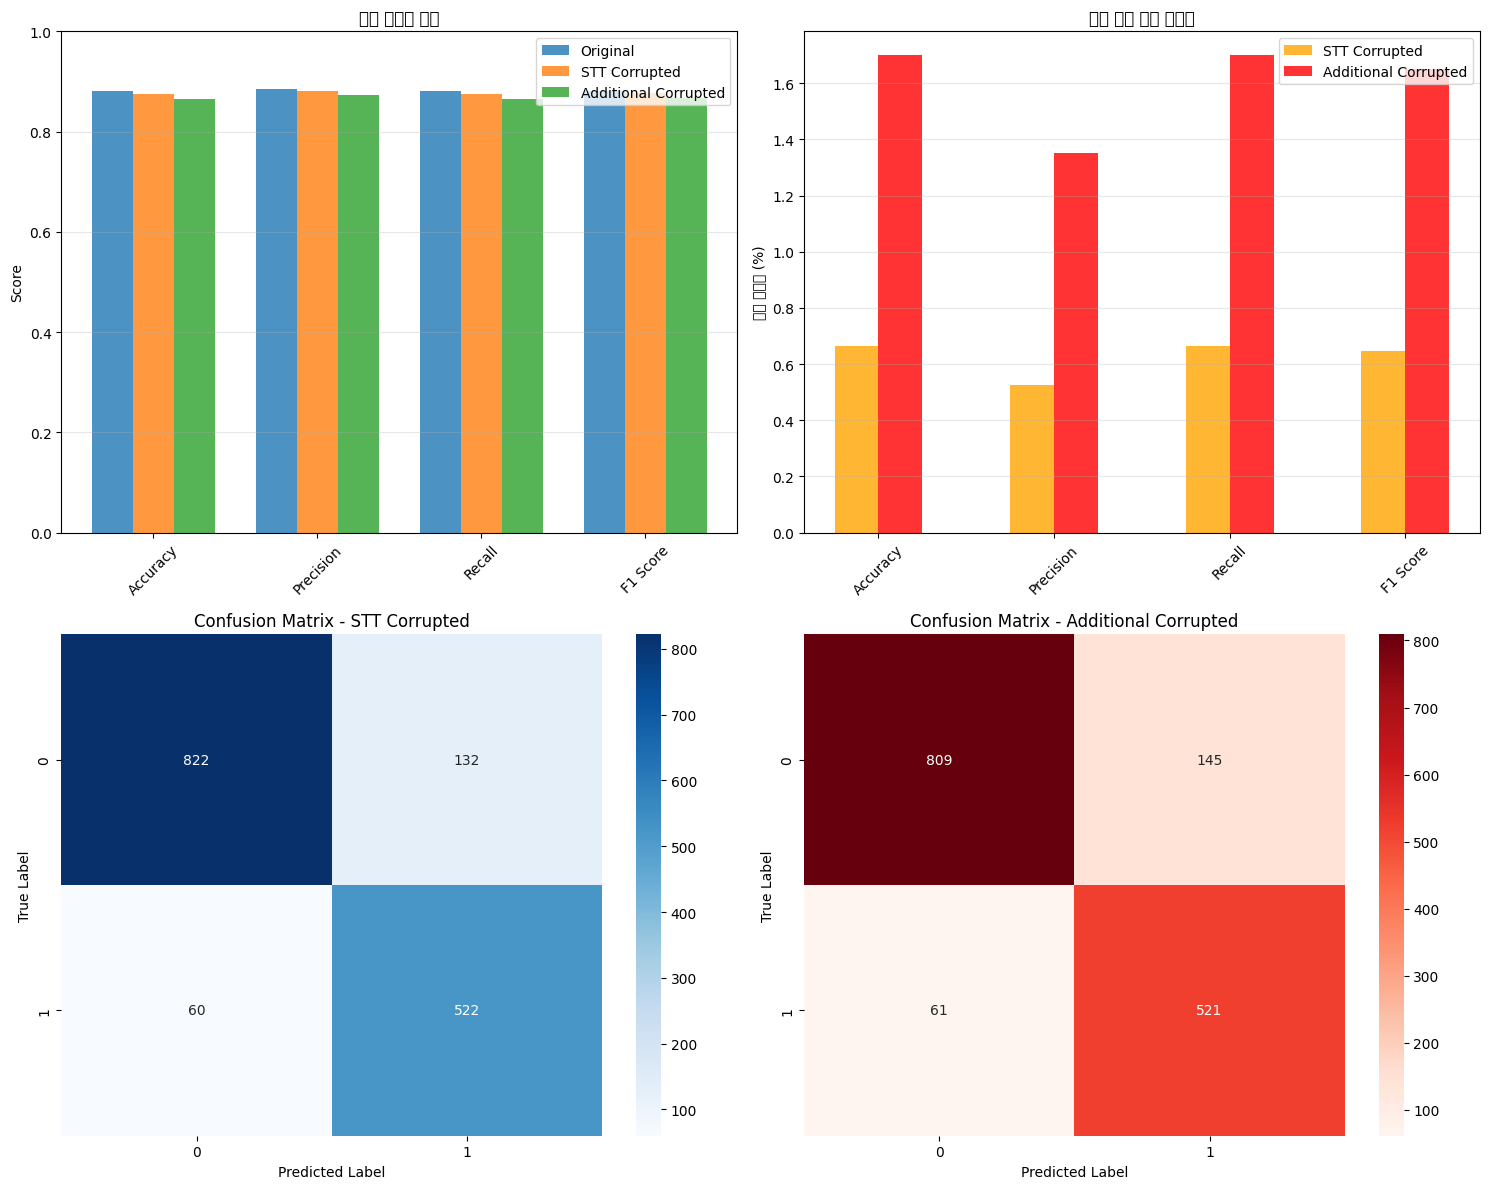


✓ 시각화 완료 (evaluation_results.png)


In [14]:
# ============================================================
# 10. 결과 비교 시각화
# ============================================================
print("\n[8단계] 결과 시각화...")

# 메트릭 비교 그래프
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 전체 메트릭 비교
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
original_metrics = [
    results['original']['accuracy'],
    results['original']['precision'],
    results['original']['recall'],
    results['original']['f1']
]
stt_metrics = [
    results['stt_corrupted']['accuracy'],
    results['stt_corrupted']['precision'],
    results['stt_corrupted']['recall'],
    results['stt_corrupted']['f1']
]
additional_metrics = [
    results['additional_corrupted']['accuracy'],
    results['additional_corrupted']['precision'],
    results['additional_corrupted']['recall'],
    results['additional_corrupted']['f1']
]

x = np.arange(len(metrics_names))
width = 0.25

axes[0, 0].bar(x - width, original_metrics, width, label='Original', alpha=0.8)
axes[0, 0].bar(x, stt_metrics, width, label='STT Corrupted', alpha=0.8)
axes[0, 0].bar(x + width, additional_metrics, width, label='Additional Corrupted', alpha=0.8)
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('전체 메트릭 비교')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# 2. 성능 저하율
degradation_stt = [(o - s) / o * 100 if o > 0 else 0
                   for o, s in zip(original_metrics, stt_metrics)]
degradation_additional = [(o - a) / o * 100 if o > 0 else 0
                          for o, a in zip(original_metrics, additional_metrics)]

axes[0, 1].bar(x - width/2, degradation_stt, width, label='STT Corrupted', alpha=0.8, color='orange')
axes[0, 1].bar(x + width/2, degradation_additional, width, label='Additional Corrupted', alpha=0.8, color='red')
axes[0, 1].set_ylabel('성능 저하율 (%)')
axes[0, 1].set_title('원본 대비 성능 저하율')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 3. Confusion Matrix - STT Corrupted
cm_stt = results['stt_corrupted']['confusion_matrix']
sns.heatmap(cm_stt, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - STT Corrupted')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 4. Confusion Matrix - Additional Corrupted
cm_additional = results['additional_corrupted']['confusion_matrix']
sns.heatmap(cm_additional, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - Additional Corrupted')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 시각화 완료 (evaluation_results.png)")

In [15]:
# ============================================================
# 11. 최종 요약 리포트
# ============================================================
print("\n" + "="*60)
print("최종 평가 요약")
print("="*60)

summary_data = {
    '데이터셋': ['원본', 'STT 손상', '추가 손상'],
    'Accuracy': [
        f"{results['original']['accuracy']:.4f}",
        f"{results['stt_corrupted']['accuracy']:.4f}",
        f"{results['additional_corrupted']['accuracy']:.4f}"
    ],
    'F1 Score': [
        f"{results['original']['f1']:.4f}",
        f"{results['stt_corrupted']['f1']:.4f}",
        f"{results['additional_corrupted']['f1']:.4f}"
    ],
    'Precision': [
        f"{results['original']['precision']:.4f}",
        f"{results['stt_corrupted']['precision']:.4f}",
        f"{results['additional_corrupted']['precision']:.4f}"
    ],
    'Recall': [
        f"{results['original']['recall']:.4f}",
        f"{results['stt_corrupted']['recall']:.4f}",
        f"{results['additional_corrupted']['recall']:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print(f"\n손상 파라미터:")
print(f"  - 추가 손상 대상 비율: {CORRUPTION_RATIO*100}%")
print(f"  - 대화 소실률: {LOSS_RATIO*100}%")

print("\n성능 저하:")
print(f"  STT 손상:")
print(f"    - Accuracy: {(results['original']['accuracy'] - results['stt_corrupted']['accuracy'])*100:.2f}% 감소")
print(f"    - F1 Score: {(results['original']['f1'] - results['stt_corrupted']['f1'])*100:.2f}% 감소")
print(f"  추가 손상:")
print(f"    - Accuracy: {(results['original']['accuracy'] - results['additional_corrupted']['accuracy'])*100:.2f}% 감소")
print(f"    - F1 Score: {(results['original']['f1'] - results['additional_corrupted']['f1'])*100:.2f}% 감소")

print("\n" + "="*60)
print("평가 완료!")
print("="*60)


최종 평가 요약

   데이터셋 Accuracy F1 Score Precision Recall
    원본   0.8809   0.8819    0.8859 0.8809
STT 손상   0.8750   0.8762    0.8813 0.8750
 추가 손상   0.8659   0.8673    0.8740 0.8659

손상 파라미터:
  - 추가 손상 대상 비율: 50.0%
  - 대화 소실률: 20.0%

성능 저하:
  STT 손상:
    - Accuracy: 0.59% 감소
    - F1 Score: 0.57% 감소
  추가 손상:
    - Accuracy: 1.50% 감소
    - F1 Score: 1.46% 감소

평가 완료!
